In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import gzip
import os
import requests
from anndata import AnnData
import scanpy as sc
from scipy import stats
import copy
import pickle
seed=314159
device='cuda'
from GPerturb_model_1 import *

# Load Replogle dataset from Bereket & Karaletsos, NeurIPS 2023
Download pre-processed dataset -> 
aws s3 cp s3://insitro-research-2023-sams-vae/data/replogle.h5ad {your dir}

In [2]:
adata = sc.read_h5ad('replogle.h5ad')
adata.obs['n_feature'] = (adata.X > 0).sum(1)

# zip
my_observation = adata.X
gene_name = list(adata.var.gene_name)
my_observation = torch.tensor(my_observation * 1.0, dtype=torch.float)

my_cell_info = adata.obs[['core_adjusted_UMI_count', 'mitopercent', 'n_feature', 'core_scale_factor']]
my_cell_info = torch.tensor(my_cell_info.to_numpy() * 1.0, dtype=torch.float)
my_cell_info[:, 2] = my_cell_info[:, 2] / my_cell_info[:, 0]
my_cell_info[:, 0] = np.log(my_cell_info[:, 0])


pathways = adata.uns['pathways']

my_conditioner = pd.get_dummies(adata.obs['gene'])
my_conditioner = my_conditioner.drop('non-targeting', axis=1)
cond_name = list(my_conditioner.columns)
my_conditioner = torch.tensor(my_conditioner.to_numpy() * 1.0, dtype=torch.float)

# Specify and train ZIP GPerturb

In [3]:
output_dim = my_observation.shape[1]
sample_size = my_observation.shape[0]
hidden_node = 1000
hidden_layer = 4
conditioner_dim = my_conditioner.shape[1]
cell_info_dim = my_cell_info.shape[1]
lr_parametric = 5e-4  
tau = torch.tensor(1.).to(device)

parametric_model = GPerturb_ZIP(conditioner_dim=conditioner_dim, output_dim=output_dim,
                                base_dim=cell_info_dim, data_size=sample_size,
                                hidden_node=hidden_node, hidden_layer_1=hidden_layer,
                                hidden_layer_2=hidden_layer, tau=tau)
parametric_model = parametric_model.to(device)

# train the model from scratch
# parametric_model.GPerturb_train(epoch=300, observation=my_observation, cell_info=my_cell_info, perturbation=my_conditioner, 
#                                 lr=lr_parametric, nu_1=5., device=device)

# load pre-trained GPerturb model
parametric_model.load_state_dict(torch.load('BSAPR_reo_ZIP_ref.pt'))

<All keys matched successfully>

# Fig 14

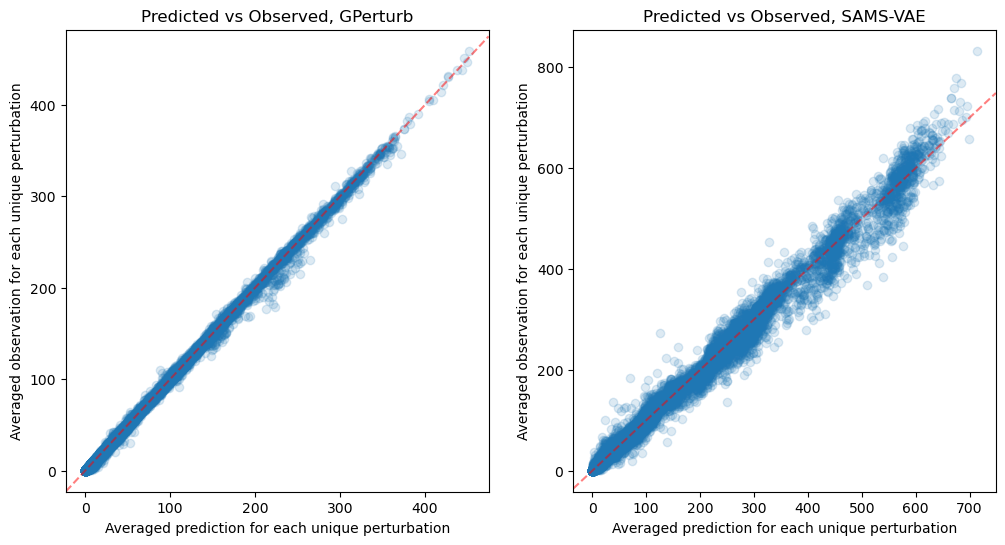

In [2]:
# compute from model
# unique_pert = adata.obs.gene.unique()
# avg_pred = np.zeros((len(unique_pert), adata.X.shape[1]))
# avg_obs = np.zeros((len(unique_pert), adata.X.shape[1]))
# for i, pert in enumerate(list(unique_pert)):
#     if i%10 == 0:
#         print(i)
#     my_id = pert == adata.obs.gene
#     predicted_mu_mean, predicted_mu_var, predicted_base_mean, logit_p, logit_p_log_var = parametric_model(my_conditioner[my_id], my_cell_info[my_id])
#     estimated_base_mean = predicted_base_mean  # * zeros[testing_idx].numpy()
#     estimated_perturbed_mean = (F.sigmoid(logit_p) * predicted_mu_mean)
#     avg_pred[i] = logexpp1(estimated_perturbed_mean + estimated_base_mean).detach().cpu().numpy().mean(0)
#     avg_obs[i] = my_observation[my_id].mean(0).numpy()

# load from pre-trained
avg_pred_GPerturb = np.loadtxt('./GPerturb_vis_data/reo_avg_pred_BSAPR_zip.csv')
avg_obs_GPerturb = np.loadtxt('./GPerturb_vis_data/reo_avg_obs_BSAPR_zip.csv')


avg_pred_SAMS = np.loadtxt('./GPerturb_vis_data/sams_vae_avg_pred.csv')
avg_obs_SAMS = np.loadtxt('./GPerturb_vis_data/sams_vae_avg_obs.csv')

fig, axes = plt.subplots(1, 2)
axes[1].scatter(avg_pred_SAMS[avg_obs_SAMS != 0], avg_obs_SAMS[avg_obs_SAMS != 0], alpha=0.15)
axes[1].axline((1, 1), slope=1, c='r', alpha=0.5, linestyle='--')
axes[1].set_xlabel('Averaged prediction for each unique perturbation')
axes[1].set_ylabel('Averaged observation for each unique perturbation')
axes[1].set_title('Predicted vs Observed, SAMS-VAE')

axes[0].scatter(avg_pred_GPerturb[avg_obs_GPerturb != 0], avg_obs_GPerturb[avg_obs_GPerturb != 0], alpha=0.15)
axes[0].axline((1, 1), slope=1, c='r', alpha=0.5, linestyle='--')
axes[0].set_xlabel('Averaged prediction for each unique perturbation')
axes[0].set_ylabel('Averaged observation for each unique perturbation')
axes[0].set_title('Predicted vs Observed, GPerturb')

fig.set_size_inches(12, 6)
# plt.savefig('./GPerturb_vis/rep_SAMS_vs_GPerturb_ZIP_3.png', dpi=300)

# Specify and train Gaussian GPerturb

In [5]:
adata = sc.read_h5ad('replogle.h5ad')
adata.obs['n_feature'] = (adata.X > 0).sum(1)
my_observation = adata.X / adata.obs.core_scale_factor.values[:, None]
gene_name = list(adata.var.gene_name)
my_observation = torch.tensor(np.log(my_observation + 1.), dtype=torch.float)

my_cell_info = adata.obs[['core_adjusted_UMI_count', 'mitopercent', 'n_feature', 'core_scale_factor']]
my_cell_info = torch.tensor(my_cell_info.to_numpy() * 1.0, dtype=torch.float)
my_cell_info[:, 2] = my_cell_info[:, 2] / my_cell_info[:, 0]
my_cell_info[:, 0] = np.log(my_cell_info[:, 0])

pathways = adata.uns['pathways']

my_conditioner = pd.get_dummies(adata.obs['gene'])
my_conditioner = my_conditioner.drop('non-targeting', axis=1)
cond_name = list(my_conditioner.columns)
my_conditioner = torch.tensor(my_conditioner.to_numpy() * 1.0, dtype=torch.float)


# design the training process:
start = time.time()
output_dim = my_observation.shape[1]
sample_size = my_observation.shape[0]
hidden_node = 1000  
hidden_layer = 4
conditioner_dim = my_conditioner.shape[1]
cell_info_dim = my_cell_info.shape[1]

lr_parametric = 1e-3  
tau = torch.tensor(1.0).to(device)

parametric_model = GPerturb_Gaussian(conditioner_dim=conditioner_dim, output_dim=output_dim, base_dim=cell_info_dim,
                                     data_size=sample_size, hidden_node=hidden_node, hidden_layer_1=hidden_layer,
                                     hidden_layer_2=hidden_layer, tau=tau)
parametric_model = parametric_model.to(device)

# train from scratch
# parametric_model.GPerturb_train(epoch=200, observation=my_observation, cell_info=my_cell_info, perturbation=my_conditioner, 
#                                 lr=lr_parametric, device=device)

# load from pre-computed
parametric_model.load_state_dict(torch.load('BSAPR_reo_Gaussian_ref.pt'))

<All keys matched successfully>

# Fig 15

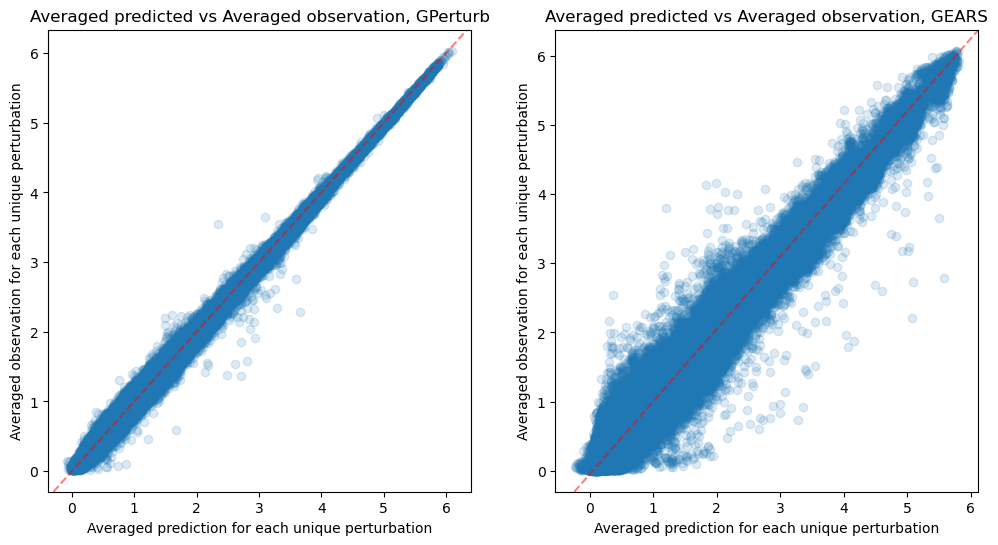

In [9]:
# compute from model
# parametric_model = parametric_model.to('cpu')
# unique_pert = adata.obs.gene.unique()
# avg_pred_GPerturb = np.zeros((len(unique_pert), adata.X.shape[1]))
# avg_obs_GPerturb = np.zeros((len(unique_pert), adata.X.shape[1]))
# for i, pert in enumerate(list(unique_pert)):
#     if i%10 == 0:
#         print(i)
#     my_id = pert == adata.obs.gene
#     predicted_mu_mean, predicted_mu_var, predicted_gamma_mean, predicted_gamma_var, \
#         logit_p, logit_p_log_var, predicted_base_mean = parametric_model(my_conditioner[my_id],
#                                                                          my_cell_info[my_id])
#     estimated_base_mean = predicted_base_mean.detach().cpu().numpy()  # * zeros[testing_idx].numpy()
#     estimated_perturbed_mean = (F.sigmoid(logit_p) * predicted_mu_mean).detach().cpu().numpy()
#     avg_pred_GPerturb[i] = (estimated_perturbed_mean + estimated_base_mean).mean(0)
#     avg_obs_GPerturb[i] = my_observation[my_id].mean(0).numpy()

# load from pre-computed
avg_pred_GPerturb = np.loadtxt('./GPerturb_vis_data/rep_avg_pred_GPerturb_Gaussian.csv')
avg_obs_GPerturb = np.loadtxt( './GPerturb_vis_data/rep_avg_obs_GPerturb_Gaussian.csv')


pert_response = pd.read_csv('./GPerturb_vis_data/rep_GEARS_pred.csv', index_col=0).to_numpy()
obs_mean_rep = np.load('./GPerturb_vis_data/avg_rep_GEARS.npy')
np.corrcoef(pert_response.ravel(), obs_mean_rep.ravel())

fig, axes = plt.subplots(1, 2)
axes[0].scatter(avg_pred_GPerturb[avg_obs_GPerturb != 0], avg_obs_GPerturb[avg_obs_GPerturb != 0], alpha=0.15)
axes[0].axline((1, 1), slope=1, c='r', alpha=0.5, linestyle='--')
axes[0].set_xlabel('Averaged prediction for each unique perturbation')
axes[0].set_ylabel('Averaged observation for each unique perturbation')
axes[0].set_title('Averaged predicted vs Averaged observation, GPerturb')

axes[1].scatter(pert_response[obs_mean_rep != 0], obs_mean_rep[obs_mean_rep != 0], alpha=0.15)
axes[1].axline((1, 1), slope=1.05, c='r', alpha=0.5, linestyle='--')
axes[1].set_xlabel('Averaged prediction for each unique perturbation')
axes[1].set_ylabel('Averaged observation for each unique perturbation')
axes[1].set_title('Averaged predicted vs Averaged observation, GEARS')


fig.set_size_inches(12, 6)
# plt.savefig('./GPerturb_vis/rep_GPerturbvsGEARS_3.png', dpi=300)

# Fig 16

In [8]:
adata = sc.read_h5ad('./GPerturb_vis_data/replogle.h5ad')
adata.obs['n_feature'] = (adata.X > 0).sum(1)

# zip
my_observation = adata.X
gene_name = list(adata.var.gene_name)
my_observation = torch.tensor(my_observation * 1.0, dtype=torch.float)

my_cell_info = adata.obs[['core_adjusted_UMI_count', 'mitopercent', 'n_feature', 'core_scale_factor']]
my_cell_info = torch.tensor(my_cell_info.to_numpy() * 1.0, dtype=torch.float)
my_cell_info[:, 2] = my_cell_info[:, 2] / my_cell_info[:, 0]
my_cell_info[:, 0] = np.log(my_cell_info[:, 0])

pathways = adata.uns['pathways']

my_conditioner = pd.get_dummies(adata.obs['gene'])
my_conditioner = my_conditioner.drop('non-targeting', axis=1)
cond_name = list(my_conditioner.columns)
my_conditioner = torch.tensor(my_conditioner.to_numpy() * 1.0, dtype=torch.float)

# compute from data
# unique_conditions = torch.unique(my_conditioner, dim=0)
# perturb_level, _, _, logit_p, _ = parametric_model(unique_conditions, None)
# estimated_inclusion_prob = F.sigmoid(logit_p).detach().cpu().numpy()
# estimated_inclusion = estimated_inclusion_prob > .95
# my_gene_name = np.array(gene_name)[estimated_inclusion.sum(axis=0) > 0]
# estimated_inclusion_prob = estimated_inclusion_prob[:, estimated_inclusion.mean(axis=0) > 0]
# estimated_pert = perturb_level.detach().cpu().numpy() * estimated_inclusion
# estimated_pert = estimated_pert[:, estimated_inclusion.mean(axis=0) > 0]

# unique_conditions = unique_conditions.numpy()
# my_yticks = ['' for _ in range(unique_conditions.shape[0])]
# ref_id = 0
# for i in range(unique_conditions.shape[0]):
#     if np.all(unique_conditions[i] == 0):
#         my_yticks[i] = 'Non Targeting'
#         ref_id = i
#     else:
#         my_yticks[i] = np.array(cond_name)[unique_conditions[i] == 1][0]

# pathway_id = {}

# for path in pathways:
#     pathway_id[path] = [my_yticks.index(i) for i in pathways[path]]


# my_yticks_rep = np.array(my_yticks)[np.concatenate(list(pathway_id.values()))]
# estimated_pert_rep = estimated_pert[np.concatenate(list(pathway_id.values()))]
# top_gene = np.argsort((estimated_pert**2).sum(axis=0))[::-1][:200]
# estimated_pert_rep = estimated_pert_rep[:, top_gene]
# my_gene_name_rep = my_gene_name[top_gene]

# load from pre-computed
estimated_pert_rep = pd.read_csv('./GPerturb_vis_data/perturb_level_Rep.csv').to_numpy()

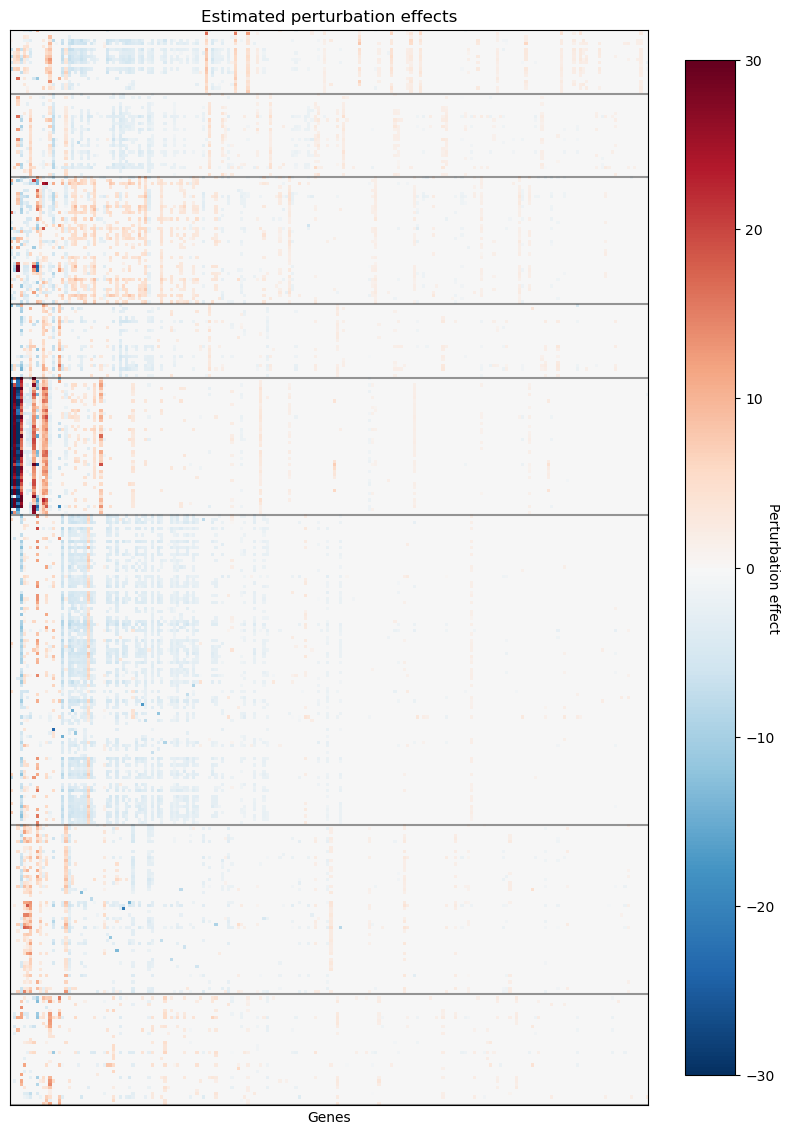

In [9]:
import matplotlib.colors as colors
fig2, axes2 = plt.subplots(1, 1)
negatives = -30 # estimated_pert_reo.min()
positives = 30 #  estimated_pert_reo.max()
num_neg_colors = int(256 / (positives - negatives) * (-negatives))
num_pos_colors = 256 - num_neg_colors
cmap_BuRd = plt.cm.RdBu_r
colors_2neg_4pos = [cmap_BuRd(0.5*c/num_neg_colors) for c in range(num_neg_colors)] +\
                   [cmap_BuRd(1-0.5*c/num_pos_colors) for c in range(num_pos_colors)][::-1]
cmap_2neg_4pos = colors.LinearSegmentedColormap.from_list('cmap_2neg_4pos', colors_2neg_4pos, N=256)

im = axes2.imshow(estimated_pert_rep, cmap=cmap_2neg_4pos, vmin=-30, vmax=30)
axes2.set_xticks([])
axes2.set_yticks([])
axes2.set_ylabel('')
for l in np.cumsum([len(i) for i in pathways.values()]):
    axes2.axline((0., l-0.5), slope=0, alpha=0.4, c='k')
axes2.set_xlabel('Genes')
axes2.set_title('Estimated perturbation effects')
axes2.set_aspect('equal')
cbar = fig2.colorbar(im, ax=axes2, fraction=0.07)
cbar.ax.set_ylabel('Perturbation effect', rotation=270)
fig2.set_size_inches(8, 12)
fig2.tight_layout()
# plt.savefig('./GPerturb_vis/perturbation_rep_ZIP_heatmap.png', dpi=300)

# Fig 17

C:\Users\86304\AppData\Local\anaconda3\envs\work_env\Lib\site-packages\anndata\_core\anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\86304\AppData\Local\anaconda3\envs\work_env\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\86304\AppData\Local\anaconda3\envs\work_env\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\86304\AppData\Local\anaconda3\envs\work_env\Lib\site-packages\scanpy\preprocessing\_pca.py:229: ImplicitModificationWarning: Sett

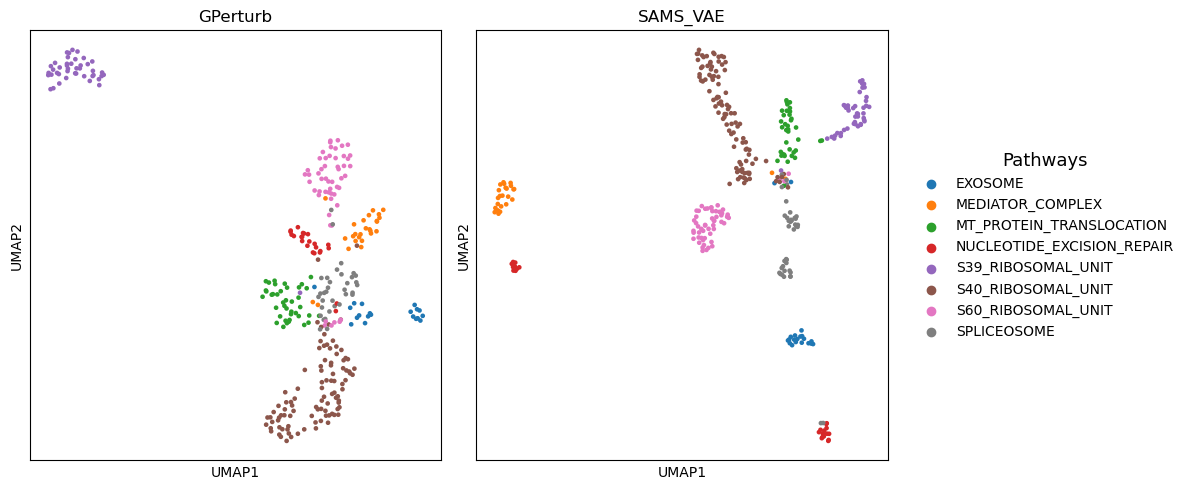

In [11]:
adata = sc.read_h5ad('./GPerturb_vis_data/replogle.h5ad')
adata.obs['n_feature'] = (adata.X > 0).sum(1)

pathways = adata.uns['pathways']

my_conditioner = pd.get_dummies(adata.obs['gene'])
my_conditioner = my_conditioner.drop('non-targeting', axis=1)
cond_name = list(my_conditioner.columns)
my_conditioner = torch.tensor(my_conditioner.to_numpy() * 1.0, dtype=torch.float)

unique_conditions = torch.unique(my_conditioner, dim=0)
unique_conditions = unique_conditions.numpy()
my_yticks = ['' for _ in range(unique_conditions.shape[0])]
ref_id = 0
for i in range(unique_conditions.shape[0]):
    if np.all(unique_conditions[i] == 0):
        my_yticks[i] = 'Non Targeting'
        ref_id = i
    else:
        my_yticks[i] = np.array(cond_name)[unique_conditions[i] == 1][0]
        
my_pathway = [None for _ in range(unique_conditions.shape[0])]
for i, name in enumerate(my_yticks):
    for j in pathways:
        if name in pathways[j]:
            my_pathway[i] = j

check_id = [_ is not None for _ in my_pathway]

# load from pre-computed

# estimated_pert = pd.read_csv('./GPerturb_vis_data/perturb_level_Rep_full.csv').to_numpy()
# top_gene = pd.read_csv('./GPerturb_vis_data/top_gene_Rep_full.csv').to_numpy().ravel()

import anndata
adata_GPerturb = anndata.AnnData(obs = pd.DataFrame(list(np.array(my_pathway)[check_id]), columns=['pathway']), X = estimated_pert[:, top_gene][check_id])

fig, ax = plt.subplots(1, 2)

sc.pp.pca(adata_GPerturb, n_comps=199)
sc.pp.neighbors(adata_GPerturb, n_neighbors=10)
sc.tl.umap(adata_GPerturb)
sc.pl.umap(adata_GPerturb, color=['pathway'], s=45, title='GPerturb', ax=ax[0], legend_loc='on_data', show=False)


adata_SAMS = sc.read_h5ad('./GPerturb_vis_data/sams_vae_embedding.h5ad')
check_id = [not pd.isna(_) for _ in list(adata_SAMS.obs.pathway)]
adata_SAMS = adata_SAMS[check_id]
sc.pp.pca(adata_SAMS, n_comps=99)
sc.pp.neighbors(adata_SAMS, n_neighbors=10)
sc.tl.umap(adata_SAMS)
sc.pl.umap(adata_SAMS, color=['pathway'], s=45, title='SAMS_VAE', ax=ax[1], show=False)
ax[1].legend(title='Pathways', title_fontsize=13, frameon=False, bbox_to_anchor=(1.04, 0.5), loc="center left")

fig.set_size_inches(12, 5)
fig.tight_layout()
# plt.savefig('./GPerturb_vis/UMAP_GPerturb_vs_SAMS_NA_filtered.png', dpi=300)